#Light GBM Notebook

Trying LGBM based on some of the discussions on kaggle around how to approach this competition in years past due to the large amount of data provided. The biggest advantages to using this approach are as follows: 


*   Can handle large data sets
*   LightGBM can use categorical features as input directly. It doesn’t need to convert to one-hot encoding, and is much faster than one-hot encoding (about 8x speed-up). (source: https://lightgbm.readthedocs.io/en/latest/Python-Intro.html)



In [ ]:
#ound this library here: 
#https://www.kaggle.com/code/nextbigwhat/train-valid-test-split-instead-of-train-test-split/notebook

!pip install fast_ml --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 kB 3.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from fast_ml.model_development import train_valid_test_split
import lightgbm as lgb
import seaborn as sns

In [ ]:
#Setting data types as catagory for auto detection by LGBM. 
#

dtypes = {
    'ip': 'category',
    'app': 'category',
    'device': 'category',
    'os': 'category',
    'channel': 'category',
    'click_time': 'str',
    'attributed_time': 'str',
    'is_attributed': 'category', 
    'hour' : 'category',
    'day' : 'category'
}

#Read in the new data with additional feature engineering. 
df3 = pd.read_csv('/content/train_v3_neat.csv', dtype=dtypes)
df3.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,hour,day,device_by_ip_day_hour,device_by_ip_app,device_by_ip_app_os,mean_of_hour_given_ip_app_device,next_click_for_ip_app_device_os,next_click_for_unique_comb_ip_app_channel_os,next_click_for_unique_comb_ip_device_channel_os
0,103175,18,1,17,376,2017-11-06 14:53:23,NaN,0,14,6,1,216,8,8.287879,27790,49120,226388
1,204158,35,1,13,21,2017-11-06 15:41:07,2017-11-07 08:17:19,1,15,6,1,1,1,15.000000,1490017133,47237,1490017133
2,11901,64,1,22,459,2017-11-06 15:45:05,NaN,0,15,6,1,17,2,10.941176,53273,53273,53273
3,23892,3,1,19,379,2017-11-06 15:50:54,NaN,0,15,6,1,275,72,7.127273,33142,46676,46539
4,79213,14,1,19,478,2017-11-06 15:57:36,NaN,0,15,6,1,269,53,11.134387,271,1490016144,31749


In [ ]:
#drop unusded cols
df3 = df3.drop(['click_time', 'attributed_time'], axis=1)
df3.head()

,ip,app,device,os,channel,is_attributed,hour,day,device_by_ip_day_hour,device_by_ip_app,device_by_ip_app_os,mean_of_hour_given_ip_app_device,next_click_for_ip_app_device_os,next_click_for_unique_comb_ip_app_channel_os,next_click_for_unique_comb_ip_device_channel_os
0,103175,18,1,17,376,0,14,6,1,216,8,8.287879,27790,49120,226388
1,204158,35,1,13,21,1,15,6,1,1,1,15.000000,1490017133,47237,1490017133
2,11901,64,1,22,459,0,15,6,1,17,2,10.941176,53273,53273,53273
3,23892,3,1,19,379,0,15,6,1,275,72,7.127273,33142,46676,46539
4,79213,14,1,19,478,0,15,6,1,269,53,11.134387,271,1490016144,31749


###Feature Selection & Data Splitting

In [ ]:
#Using fast_ml library to create a train, validation and test set
x_train, y_train, x_valid, y_valid, x_test, y_test = train_valid_test_split(df3, 
                                                                            target = 'is_attributed', 
                                                                            train_size=0.8, 
                                                                            valid_size=0.1, 
                                                                            test_size=0.1)

print(x_train.shape), print(y_train.shape)
print(x_valid.shape), print(y_valid.shape)
print(x_test.shape), print(y_test.shape)

(765476, 14)
(765476,)
(95685, 14)
(95685,)
(95685, 14)
(95685,)


(None, None)

In [ ]:
#Selecting features and setting label
#features = df3[['ip', 'app', 'device', 'os', 'channel', 'hour', 'day', 'next_click_for_ip_app_device_os', 'next_click_for_unique_comb_ip_app_channel_os', 'next_click_for_unique_comb_ip_device_channel_os']]
#labels = df3['is_attributed']
#print(features.shape)
#print(labels.shape)

#x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.01, random_state=42)
#print(x_train.shape, y_train.shape)
#print(x_test.shape, y_test.shape)

(956846, 10)
(956846,)
(947277, 10) (947277,)
(9569, 10) (9569,)


In [ ]:
#Building a very simple LGM Model
#default settings are as follows for LGBMClassifier
               #(boosting_type='gbdt', num_leaves=31, max_depth=-1, learning_rate=0.1, 
               #n_estimators=100, subsample_for_bin=200000, objective=None, class_weight=None, 
               #min_split_gain=0.0, min_child_weight=0.001, min_child_samples=20, subsample=1.0, 
               #subsample_freq=0, colsample_bytree=1.0, reg_alpha=0.0, reg_lambda=0.0, 
               #random_state=None, n_jobs=None, importance_type='split', **kwargs)

#Adjusted subsample_for_bin=200000 to 100000 with no change in model accuracy
#Should try learning rate adjustment?
#Should try feature adustment?
#Cross Validation?

lgb_model = lgb.LGBMClassifier()

#default parameters for .fit: (X, y, sample_weight=None, init_score=None, eval_set=None, eval_names=None, 
                              #eval_sample_weight=None, eval_class_weight=None, eval_init_score=None, 
                              #eval_metric=None, feature_name='auto', categorical_feature='auto', 
                              #callbacks=None, init_model=None)
#No need to set catagorical features as the default is 'auto' 
#additional sources that were used to evaluate this are as follows: 
              #https://www.kaggle.com/getting-started/203471  
              #https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html
              
lgb_model.fit(x_train, y_train)

LGBMClassifier()

In [ ]:
#predicting the labes on x_valid
y_valid_pred = lgb_model.predict(x_valid)

#Checking the accuracy of our model based on our predictions: Valid Set
print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy_score(y_valid, y_valid_pred)))

LightGBM Model accuracy score: 0.9394


In [ ]:
#looking at the accuracy of our training set
y_pred_train = lgb_model.predict(x_train)
print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train)))

Training-set accuracy score: 0.9435


In [ ]:
#Checking for overfitting
#They are close and do not suspect any overfitting occuring. 
print('Training set score: {:.4f}'.format(lgb_model.score(x_train, y_train)))
print('Validation set score: {:.4f}'.format(lgb_model.score(x_valid, y_valid)))

Training set score: 0.9435
Validation set score: 0.9394


Confusion Matrix
 [[48079  1850]
 [ 3952 41804]]


<Axes: >

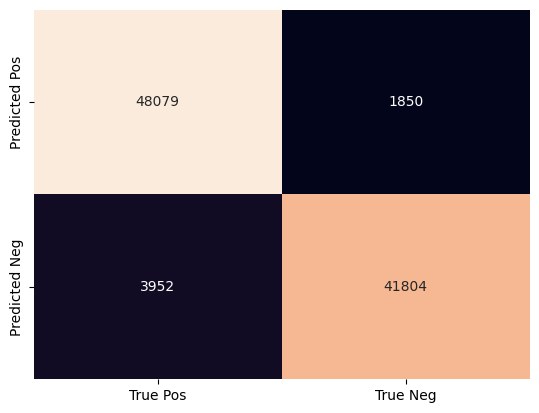

In [ ]:
#Confusion Matrix of the validation set
conf_matrix = confusion_matrix(y_valid, y_valid_pred)
print('Confusion Matrix\n', conf_matrix)

#Heatmap
conf_matrix_hm = pd.DataFrame(data=conf_matrix, columns=['True Pos', 'True Neg'], index=['Predicted Pos', 'Predicted Neg'])
sns.heatmap(conf_matrix_hm, annot=True, fmt='d', cbar=False)

In [ ]:
print(classification_report(y_valid, y_valid_pred))

              precision    recall  f1-score   support

           0       0.92      0.96      0.94     49929
           1       0.96      0.91      0.94     45756

    accuracy                           0.94     95685
   macro avg       0.94      0.94      0.94     95685
weighted avg       0.94      0.94      0.94     95685



###Test Set for Training

In [ ]:
#predicting the labes on x_test created from the training set
y_test_pred = lgb_model.predict(x_test)

#Checking the accuracy of our model based on our predictions: test Set
print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test, y_test_pred)))